다운 받은 grib 파일의 변수들(X값들) 확인  
feature_final.grib  
feature_final_2.grib  
이 두 파일은 ECMWF에서 다운받음

파일 용량이 커지면 데이터 손실이 일어나서 두 파일로 나누어 저장함

In [25]:
import eccodes
from collections import defaultdict
import os
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [22]:
grib_path = "feature_final.grib"

features = defaultdict(set)
with open(grib_path, 'rb') as f:
    while True:
        try:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            short_name = eccodes.codes_get(gid, "shortName")
            param_id = eccodes.codes_get(gid, "paramId")
            features[short_name].add(param_id)
            eccodes.codes_release(gid)
        except eccodes.CodesInternalError:
            break

print("📦 GRIB 변수 목록:")
for short_name, param_ids in sorted(features.items()):
    for param_id in param_ids:
        print(f"- {short_name} (paramId={param_id})")


📦 GRIB 변수 목록:
- 10u (paramId=165)
- 10v (paramId=166)
- 2t (paramId=167)
- asn (paramId=32)
- msl (paramId=151)
- sf (paramId=144)
- sshf (paramId=146)
- sst (paramId=34)
- tcc (paramId=164)
- tcwv (paramId=137)
- tp (paramId=228)


In [23]:
grib_path = "feature_final_2.grib"

features = defaultdict(set)
with open(grib_path, 'rb') as f:
    while True:
        try:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            short_name = eccodes.codes_get(gid, "shortName")
            param_id = eccodes.codes_get(gid, "paramId")
            features[short_name].add(param_id)
            eccodes.codes_release(gid)
        except eccodes.CodesInternalError:
            break

print("📦 GRIB 변수 목록:")
for short_name, param_ids in sorted(features.items()):
    for param_id in param_ids:
        print(f"- {short_name} (paramId={param_id})")


📦 GRIB 변수 목록:
- 10u (paramId=165)
- 10v (paramId=166)
- 2t (paramId=167)
- asn (paramId=32)
- msl (paramId=151)
- sf (paramId=144)
- sshf (paramId=146)
- sst (paramId=34)
- tcc (paramId=164)
- tcwv (paramId=137)
- tp (paramId=228)


총 11개의 변수가 확인됨  
이때 msl 변수는 결측치 문제로 제외하고,  
asn, sf, sshf, sst, tcc, tcwv, tp와 10u, 10v, 2t(t2m)의 파일 저장 방식이 달라 두 정보를 다르게 추출해야 함

그래서 총 4번 npy 파일 저장 필요!

참고로 아래 4개 코드 시간 많이 걸림

In [ ]:
# 1. 대상 변수 설정
target_variables = [
    {"shortName": "asn", "typeOfLevel": "surface"},
    {"shortName": "sf", "typeOfLevel": "surface"},
    {"shortName": "sshf", "typeOfLevel": "surface"},
    {"shortName": "sst", "typeOfLevel": "surface"},
    {"shortName": "tcc", "typeOfLevel": "surface"},
    {"shortName": "tcwv", "typeOfLevel": "surface"},
    {"shortName": "tp", "typeOfLevel": "surface"},
]

# 2. 경로 및 출력 디렉토리
grib_path = "feature_final.grib"
out_dir = "npy"
os.makedirs(out_dir, exist_ok=True)

# 3. 격자 정의 (25km 픽셀, 중심은 북극)
dx = dy = 25000
x = np.linspace(-150 * dx, 150 * dx, 300)
y = np.linspace(-214 * dy, 214 * dy, 428)
xv, yv = np.meshgrid(x, y)
grid_points = (xv, yv)

# 4. 투영 설정
proj = ccrs.NorthPolarStereo()
pc = ccrs.PlateCarree()

# 5. 각 변수 반복 처리
for var_filter in target_variables:
    try:
        ds = xr.open_dataset(grib_path, engine="cfgrib", filter_by_keys=var_filter)
        var_name = var_filter["shortName"]

        # 위경도 → 투영 좌표
        lons = ds['longitude'].values
        lats = ds['latitude'].values
        lon2d, lat2d = np.meshgrid(lons, lats)
        points_proj = proj.transform_points(pc, lon2d, lat2d)
        x_src = points_proj[..., 0]
        y_src = points_proj[..., 1]

        # 3. 반시계 방향으로 45도 회전
        theta = np.radians(45)
        x_rot = x_src * np.cos(theta) - y_src * np.sin(theta)
        y_rot = x_src * np.sin(theta) + y_src * np.cos(theta)
        rotated_points = np.vstack((x_rot.flatten(), y_rot.flatten())).T

        for t in range(len(ds["time"])):
            data = ds[var_name].isel(time=t).values.flatten()

            # 보간 (회전된 좌표 기준)
            grid_z = griddata(rotated_points, data, grid_points, method="linear")

            # 저장
            time_str = str(ds["time"].values[t])[:10].replace(":", "-")
            filename = f"{var_name}_{time_str}.npy"
            np.save(os.path.join(out_dir, filename), grid_z)

            print(f"✅ 저장 완료: {filename}")

    except Exception as e:
        print(f"❌ 변수 {var_filter} 처리 중 오류 발생: {e}")


In [ ]:
# 1. 대상 변수 설정
target_variables = [
    {"shortName": "asn", "typeOfLevel": "surface"},
    {"shortName": "sf", "typeOfLevel": "surface"},
    {"shortName": "sshf", "typeOfLevel": "surface"},
    {"shortName": "sst", "typeOfLevel": "surface"},
    {"shortName": "tcc", "typeOfLevel": "surface"},
    {"shortName": "tcwv", "typeOfLevel": "surface"},
    {"shortName": "tp", "typeOfLevel": "surface"},
]

# 2. 경로 및 출력 디렉토리
grib_path = "feature_final_2.grib"
out_dir = "npy"
os.makedirs(out_dir, exist_ok=True)

# 3. 격자 정의 (25km 픽셀, 중심은 북극)
dx = dy = 25000
x = np.linspace(-150 * dx, 150 * dx, 300)
y = np.linspace(-214 * dy, 214 * dy, 428)
xv, yv = np.meshgrid(x, y)
grid_points = (xv, yv)

# 4. 투영 설정
proj = ccrs.NorthPolarStereo()
pc = ccrs.PlateCarree()

# 5. 각 변수 반복 처리
for var_filter in target_variables:
    try:
        ds = xr.open_dataset(grib_path, engine="cfgrib", filter_by_keys=var_filter)
        var_name = var_filter["shortName"]

        # 위경도 → 투영 좌표
        lons = ds['longitude'].values
        lats = ds['latitude'].values
        lon2d, lat2d = np.meshgrid(lons, lats)
        points_proj = proj.transform_points(pc, lon2d, lat2d)
        x_src = points_proj[..., 0]
        y_src = points_proj[..., 1]

        # 3. 반시계 방향으로 45도 회전
        theta = np.radians(45)
        x_rot = x_src * np.cos(theta) - y_src * np.sin(theta)
        y_rot = x_src * np.sin(theta) + y_src * np.cos(theta)
        rotated_points = np.vstack((x_rot.flatten(), y_rot.flatten())).T

        for t in range(len(ds["time"])):
            data = ds[var_name].isel(time=t).values.flatten()

            # 보간 (회전된 좌표 기준)
            grid_z = griddata(rotated_points, data, grid_points, method="linear")

            # 저장
            time_str = str(ds["time"].values[t])[:10].replace(":", "-")
            filename = f"{var_name}_{time_str}.npy"
            np.save(os.path.join(out_dir, filename), grid_z)

            print(f"✅ 저장 완료: {filename}")

    except Exception as e:
        print(f"❌ 변수 {var_filter} 처리 중 오류 발생: {e}")


In [ ]:

# 1. 파일 열기
ds = xr.open_dataset("feature_final_2.grib", engine="cfgrib")

# 2. 위경도 → 투영 변환
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

proj = ccrs.NorthPolarStereo()
pc = ccrs.PlateCarree()
points_proj = proj.transform_points(pc, lon2d, lat2d)
x_src = points_proj[..., 0]
y_src = points_proj[..., 1]

# 3. 좌표 회전 (반시계 방향 45도)
theta = np.radians(45)
x_rot = x_src * np.cos(theta) - y_src * np.sin(theta)
y_rot = x_src * np.sin(theta) + y_src * np.cos(theta)
rotated_points = np.vstack((x_rot.flatten(), y_rot.flatten())).T

# 4. 목적 격자 정의 (25km 정사각형 격자, 북극 중심)
dx = dy = 25_000
x = np.linspace(-150 * dx, 150 * dx, 300)
y = np.linspace(-214 * dy, 214 * dy, 428)
xv, yv = np.meshgrid(x, y)
grid_points = (xv, yv)

# 5. 저장 경로 설정
out_dir = "npy"
os.makedirs(out_dir, exist_ok=True)

# 6. 저장할 변수 목록
target_vars = ["u10", "v10", "t2m"]

# 7. 변수별 저장
for var_name in target_vars:
    if var_name not in ds:
        print(f"⚠️ 변수 {var_name}는 데이터셋에 존재하지 않습니다.")
        continue

    var = ds[var_name]
    print(f"📦 처리 중: {var_name}")

    if "time" in var.dims:
        for t_idx in range(var.sizes["time"]):
            try:
                values = var.isel(time=t_idx).values.flatten()

                # 보간 수행 (회전된 좌표 기준)
                grid_z = griddata(rotated_points, values, grid_points, method="linear")

                time_val = str(ds["time"].values[t_idx])[:10].replace(":", "-")
                filename = f"{var_name}_{time_val}.npy"
                np.save(os.path.join(out_dir, filename), grid_z)
                print(f"✅ 저장 완료: {filename}")
            except Exception as e:
                print(f"❌ 오류: {var_name} 시간 {t_idx} → {e}")
    else:
        try:
            values = var.values.flatten()
            grid_z = griddata(rotated_points, values, grid_points, method="linear")
            filename = f"{var_name}_static.npy"
            np.save(os.path.join(out_dir, filename), grid_z)
            print(f"✅ 저장 완료: {filename}")
        except Exception as e:
            print(f"❌ 오류: {var_name} → {e}")

In [ ]:
# 1. 파일 열기
ds = xr.open_dataset("feature_final.grib", engine="cfgrib")

# 2. 위경도 → 투영 변환
lons = ds.longitude.values
lats = ds.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

proj = ccrs.NorthPolarStereo()
pc = ccrs.PlateCarree()
points_proj = proj.transform_points(pc, lon2d, lat2d)
x_src = points_proj[..., 0]
y_src = points_proj[..., 1]

# 3. 좌표 회전 (반시계 방향 45도)
theta = np.radians(45)
x_rot = x_src * np.cos(theta) - y_src * np.sin(theta)
y_rot = x_src * np.sin(theta) + y_src * np.cos(theta)
rotated_points = np.vstack((x_rot.flatten(), y_rot.flatten())).T

# 4. 목적 격자 정의 (25km 정사각형 격자, 북극 중심)
dx = dy = 25_000
x = np.linspace(-150 * dx, 150 * dx, 300)
y = np.linspace(-214 * dy, 214 * dy, 428)
xv, yv = np.meshgrid(x, y)
grid_points = (xv, yv)

# 5. 저장 경로 설정
out_dir = "npy"
os.makedirs(out_dir, exist_ok=True)

# 6. 저장할 변수 목록
target_vars = ["u10", "v10", "t2m"]

# 7. 변수별 저장
for var_name in target_vars:
    if var_name not in ds:
        print(f"⚠️ 변수 {var_name}는 데이터셋에 존재하지 않습니다.")
        continue

    var = ds[var_name]
    print(f"📦 처리 중: {var_name}")

    if "time" in var.dims:
        for t_idx in range(var.sizes["time"]):
            try:
                values = var.isel(time=t_idx).values.flatten()

                # 보간 수행 (회전된 좌표 기준)
                grid_z = griddata(rotated_points, values, grid_points, method="linear")

                time_val = str(ds["time"].values[t_idx])[:10].replace(":", "-")
                filename = f"{var_name}_{time_val}.npy"
                np.save(os.path.join(out_dir, filename), grid_z)
                print(f"✅ 저장 완료: {filename}")
            except Exception as e:
                print(f"❌ 오류: {var_name} 시간 {t_idx} → {e}")
    else:
        try:
            values = var.values.flatten()
            grid_z = griddata(rotated_points, values, grid_points, method="linear")
            filename = f"{var_name}_static.npy"
            np.save(os.path.join(out_dir, filename), grid_z)
            print(f"✅ 저장 완료: {filename}")
        except Exception as e:
            print(f"❌ 오류: {var_name} → {e}")

위에서 모든 npy 파일을 npz 파일 하나로 저장

In [26]:
# 폴더 경로와 저장 위치
npy_dir = "./npy"
output_npz = "feature_real_final.npz"

# 모든 npy 파일 목록 불러오기
all_files = sorted([f for f in os.listdir(npy_dir) if f.endswith(".npy")])

# feature별로 그룹화
feature_dict = defaultdict(list)
for fname in all_files:
    feature, date = fname.replace(".npy", "").split("_")
    feature_dict[feature].append((date, fname))

# feature 이름 정렬
features = sorted(feature_dict.keys())
num_features = len(features)
num_timesteps = 360

# 기준 shape 확보
sample_array = np.load(os.path.join(npy_dir, all_files[0]))
y_size, x_size = sample_array.shape

# 결과 배열 초기화
merged = np.zeros((num_timesteps, num_features, y_size, x_size), dtype=np.float32)

# feature 순서대로 반복
for f_idx, feature in enumerate(features):
    # 날짜순 정렬
    sorted_files = sorted(feature_dict[feature])[:360]
    
    for t_idx, (date, fname) in enumerate(sorted_files):
        array = np.load(os.path.join(npy_dir, fname))
        merged[t_idx, f_idx] = array  # (y, x) 형태로 들어가 있음

# 저장
np.savez(output_npz, data=merged, features=features)
print(f"✅ Saved: {output_npz}")


✅ Saved: feature_real_final.npz


실제로 잘 맞는지 확인

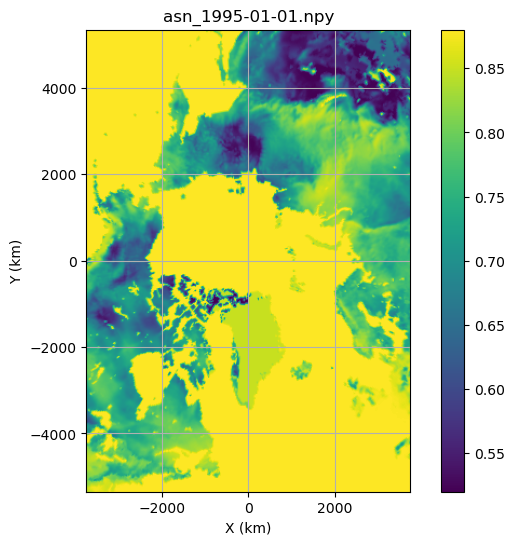

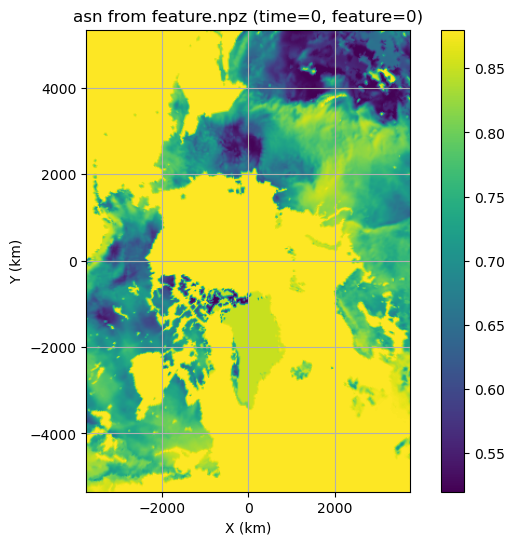

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

npy_dir = "./npy"
output_npz = "feature_real_final.npz"

# 픽셀 크기 (25km)
dx = dy = 25000  # meters
x = np.linspace(-150 * dx, 150 * dx, 300) / 1000  # km
y = np.linspace(-214 * dy, 214 * dy, 428) / 1000  # km

# (1) asn_2019-01-01.npy 시각화
asn_path = os.path.join(npy_dir, "asn_1995-01-01.npy")
asn_data = np.load(asn_path)

plt.figure(figsize=(8, 6))
plt.imshow(asn_data, extent=[x[0], x[-1], y[0], y[-1]], origin='lower', cmap='viridis')
plt.title("asn_1995-01-01.npy")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.colorbar()
plt.grid(True)
plt.show()

# (2) feature_temp.npz의 0번째 timestep, asn (feature 0번) 시각화
npz = np.load(output_npz)
npz_data = npz["data"]  # shape: (time, feature, y, x)

asn_from_npz = npz_data[0, 0]

plt.figure(figsize=(8, 6))
plt.imshow(asn_from_npz, origin="lower", extent=[x[0], x[-1], y[0], y[-1]])
plt.title("asn from feature.npz (time=0, feature=0)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.colorbar()
plt.grid(True)
plt.show()


여기 위까지 전처리 완료!

In [ ]:
import numpy as np

# npz 파일 경로
npz_path = "NSIDC_x_y.npz"  # 실제 파일 이름으로 변경하세요

# 파일 로드
data = np.load(npz_path)

# key 목록 출력
print("🗂 포함된 배열 목록 (keys):")
for key in data.files:
    print(f" - {key}")

print("\n🧩 각 배열의 상세 구조:")
# 각 배열의 정보 출력
for key in data.files:
    arr = data[key]
    print(f"\n🔑 배열 이름: {key}")
    print(f" - shape: {arr.shape}")
    print(f" - dtype: {arr.dtype}")
    print(f" - 예시 값 (앞부분):\n{arr[:5]}")


🗂 포함된 배열 목록 (keys):
 - sic
 - x
 - y
 - dates
 - file_list

🧩 각 배열의 상세 구조:

🔑 배열 이름: sic
 - shape: (360, 448, 304)
 - dtype: float32
 - 예시 값 (앞부분):
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

🔑 배열 이름: x
 - shape: (304,)
 - 

✅ 구조 요약
입력 데이터: NSIDC_x_y.npz, 0_feature.npz

지원 모델: MLP, LSTM, GRU, Transformer, ConvLSTM, UNet

입력 방식: SIC 단독 / SIC + Feature

예측 지연: 1개월 / 3개월

Window Size: 12개월 / 36개월

Data Split:

288 train / 36 val / 36 test

288 train / 72 test (window: 12)

288 train / 72 test (window: 36)

지표: MAE / MSE / RMSE